In [24]:
# Essential Libraries
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer,  precision_score,  recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
# Initialize JavaScript for SHAP visualizations
shap.initjs()

#### Aim
To compare the ability of three different sequencing technologies in classifying soils of different origin or that underwent different treatments

#### In each of the main dataset files (e.g. Aviti_raw_data.txt):
- Rows = Genus (features)
- Columns = Sample names (numbers like 1, 2, 3, ..., 36)
  
#### In the metadata/label file (Metadata.xlsx):
- First column = Sample names (but with extra characters, e.g., "T1-2", etc.)
- Second column onward = treatment/condition type (categorical label)

🧾 Sample names with their respective labels:
   Sample_Name Soil_Type  Soil_Label
0            1        No           0
1            2        No           0
2            3        No           0
3            4        No           0
4            5        No           0
5            6        No           0
6            7       Yes           1
7            8       Yes           1
8            9       Yes           1
9           10       Yes           1
10          11       Yes           1
11          12       Yes           1
12          13        No           0
13          14        No           0
14          15        No           0
15          16        No           0
16          17        No           0
17          18        No           0
18          19       Yes           1
19          20       Yes           1
20          21       Yes           1
21          22       Yes           1
22          23       Yes           1
23          24       Yes           1
24          25        No      

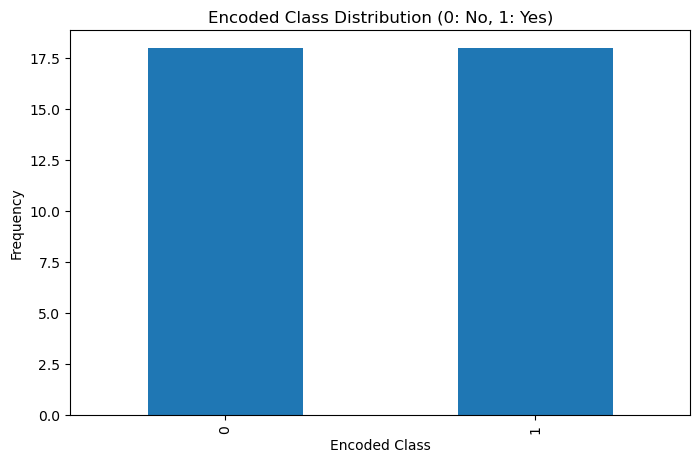

In [118]:
# Load and transpose the main data
# Aviti_raw_data
# X = pd.read_csv('Aviti_raw_data.txt', delimiter='\t', index_col=0).T
# Miseq_raw_data
# X = pd.read_csv('Miseq_raw_data.txt', delimiter='\t', index_col=0).T
# Novaseq_raw_data
X = pd.read_csv('Novaseq_raw_data.txt', delimiter='\t', index_col=0).T
X.index = X.index.astype(str)

# Load metadata
metadata = pd.read_excel('Metadata.xlsx')

# Extract digits after the first 3 characters
metadata['Sample_num'] = metadata['Sample_name'].astype(str).str.slice(3).str.extract(r'(\d+)')[0]

# Create a mapping from numeric sample name → soil type
# sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Soil']))
# Create a mapping from numeric sample name → Autoclave type
# sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Autoclave']))
# Create a mapping from numeric sample name → Heat root type
sample_to_condition = dict(zip(metadata['Sample_num'], metadata['Heat root']))

# Map sample names in X to soil types
y_raw = X.index.map(sample_to_condition)

# Keep only samples with valid labels
valid_samples = y_raw.notna()
X = X[valid_samples]
y_raw = y_raw[valid_samples]
feature_names = X.columns.tolist()
# Encode soil types
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Create a DataFrame showing sample names and their labels ---> for debugging purpose
labels_df = pd.DataFrame({
    'Sample_Name': X.index,
    'Soil_Type': y_raw.values,
    'Soil_Label': y
})

# Display the result
print("🧾 Sample names with their respective labels:")
print(labels_df)



print("Encoded Class Distribution:")
print(pd.Series(y).value_counts())
# Plot the class distribution
plt.figure(figsize=(8, 5))
pd.Series(y).value_counts().plot(kind='bar')
# when condition = soil
# plt.title('Encoded Class Distribution (0: Manure, 1: Peat, 2: Sand')
#  when condition = autoclave or Heat root
plt.title('Encoded Class Distribution (0: No, 1: Yes)')
plt.xlabel('Encoded Class')
plt.ylabel('Frequency')
plt.show()

# Check for missing values --> none
# print(f"Columns with missing values: {data.columns[data.isnull().any()].tolist()}")
# # Feature selection ------------------>??
# rf = RandomForestClassifier(n_estimators=15, random_state=42)
# rf.fit(X, y)
# feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
# # Count the number of features with 0.0 importance and print their names -----> only 46 is important out of 1017 when label is soil
# zero_importance_features = feature_importances[feature_importances == 0.0].index.tolist()
# print(f"\nNumber of features with 0.0 importance: {len(zero_importance_features)}")
# print("Features with 0.0 importance:", zero_importance_features)
# print("\nFeature Importances:")
# print(feature_importances.sort_values(ascending=False))
# # Remove zero importance features from X
# X_reduced = X.drop(columns=zero_importance_features) 
# feature_names_reduced = X_reduced.columns.tolist()
# print("\nX_reduced.shape is ", X_reduced.shape)
# print("\nX_reduced names.shape is ", len(feature_names_reduced))
# print(feature_names_reduced)

In [119]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Show the shapes of the splits
print("📊 Train set shape:", X_train.shape)
print("📊 Test set shape:", X_test.shape)


📊 Train set shape: (27, 1316)
📊 Test set shape: (9, 1316)


C:\Users\hassa\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}

Cross-Validation Scores from GridSearchCV:
      mean_test_score  std_test_score  \
0           0.486667        0.106667   
1           0.360000        0.213333   
2           0.433333        0.152023   
3           0.500000        0.223109   
4           0.440000        0.135647   
..               ...             ...   
283         0.346667        0.291052   
284         0.580000        0.165462   
285         0.460000        0.310125   
286         0.353333        0.195050   
287         0.313333        0.238141   

                                                params  
0    {'max_depth': None, 'max_features': 'sqrt', 'm...  
1    {'max_depth': None, 'max_features': 'sqrt', 'm...  
2    {'max_depth': None, 'max_features': 'sqrt', 'm...  
3    {'max_depth': None, 'max_features': 'sqrt', 'm...  
4    {'max_depth': None, 'max_features': '

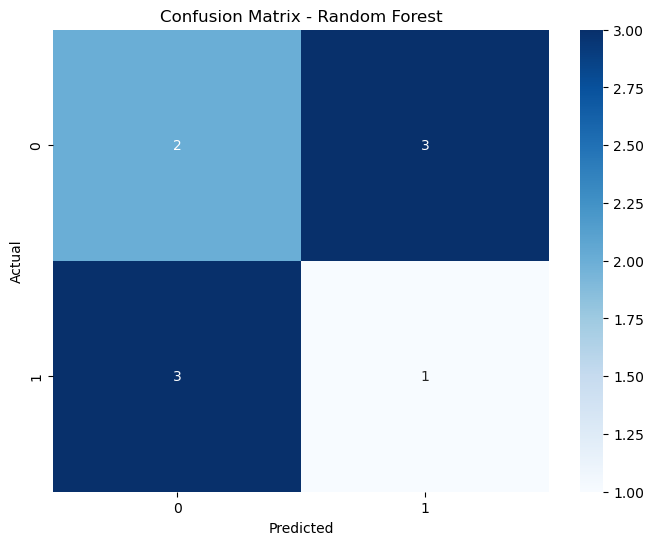

Random Forest shap_values shape is (9, 1316, 2)
Selected SHAP values shape: (9, 1316)


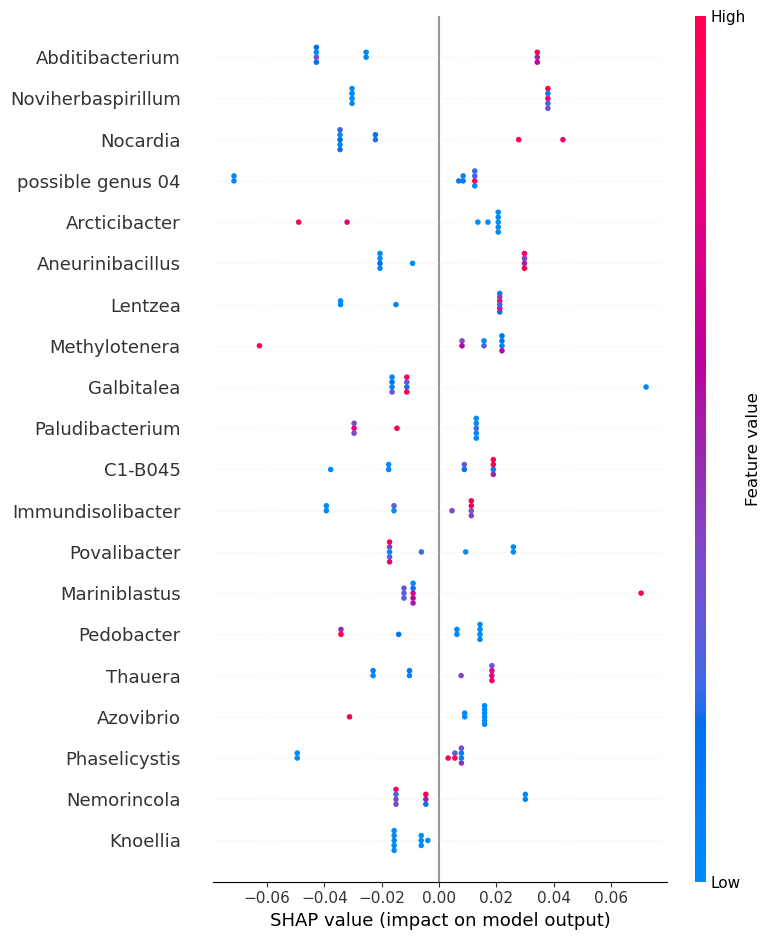

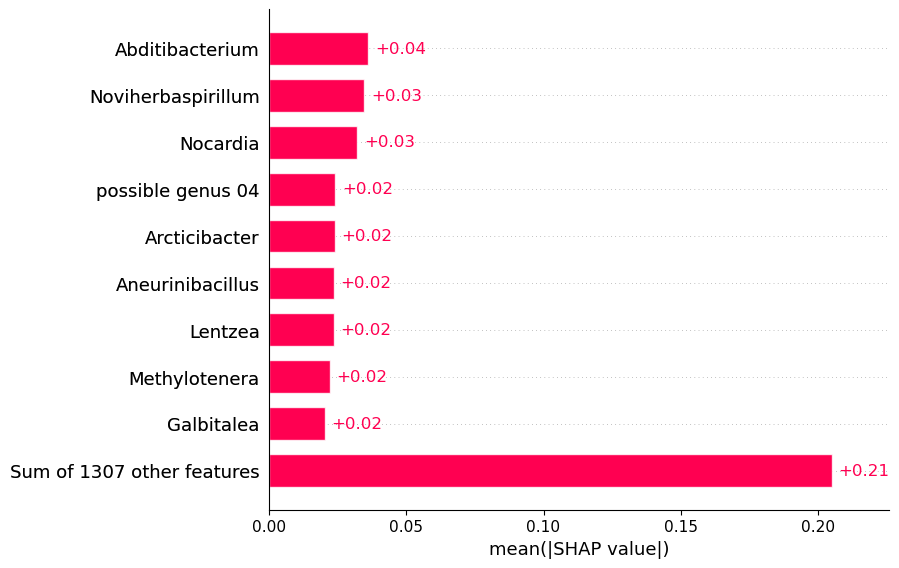

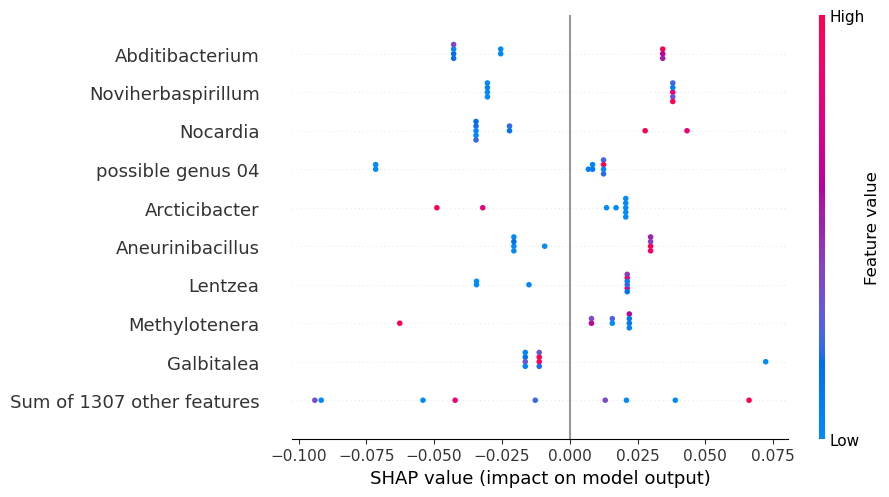

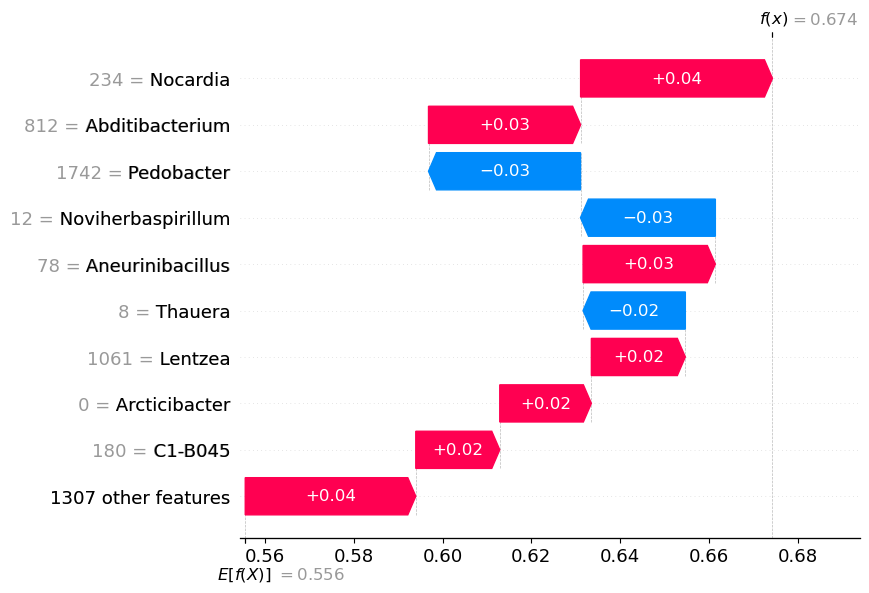

Model classes: [0 1]


In [120]:
### Random Forest Classifier ###
# Hyperparameter Tuning and Cross-Validation for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
# Set a random_state for reproducibility
random_state = 42
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest:", best_params_rf)

# Print Cross-Validation Scores from GridSearchCV
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
print("\nCross-Validation Scores from GridSearchCV:\n", cv_results_rf[['mean_test_score', 'std_test_score', 'params']])

# Initialize the best Random Forest model
rf_model = RandomForestClassifier(**best_params_rf,random_state=random_state)

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation for Random Forest
print("\nRandom Forest - Test Set Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_rf))

# make sure the labels match
print("Unique values in y_test:", np.unique(y_test))

# Confusion Matrix
class_labels = rf_model.classes_
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SHAP Analysis, on train/test set
# Use TreeExplainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)

# Calculate SHAP values
# shap_values_rf = explainer_rf.shap_values(X_train)
shap_values_rf = explainer_rf.shap_values(X_test)
print("Random Forest shap_values shape is", np.shape(shap_values_rf))

# Select the SHAP values for the positive class (class 1)
shap_values_rf_selected = shap_values_rf[:, :, 1]
# Print the shape of the resulting array
print("Selected SHAP values shape:", shap_values_rf_selected.shape)

# Create an Explanation object
shap_values_rf_explanation = shap.Explanation(
    shap_values_rf_selected,
    base_values=explainer_rf.expected_value[1],  # Use the expected value of the positive class
    # data=X_train,
    data=X_test,
    feature_names=feature_names
    # feature_names=feature_names_reduced
)

# Generate SHAP plots for the Train/test set
# Summary Plot
# shap.summary_plot(shap_values_rf_explanation, X_train, feature_names=feature_names)
shap.summary_plot(shap_values_rf_explanation, X_test, feature_names=feature_names)
# shap.summary_plot(shap_values_rf_explanation, X_train, feature_names=feature_names_reduced)
# Bar Plot
shap.plots.bar(shap_values_rf_explanation)

# Beeswarm Plot
shap.plots.beeswarm(shap_values_rf_explanation)

# Waterfall Plot for the first instance
shap.plots.waterfall(shap_values_rf_explanation[0])

print("Model classes:", rf_model.classes_)